# Assignment 1 - DAX ESG dataset

## This notebook
This notebook is boiler plate code that can be re-used for loading the data.

## Interesting resources
- Source of the "actions" dataset: [Bridging the Gap in ESG Measurement: Using NLP to Quantify Environmental, Social, and Governance Communication](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4622514)
- Source of the target "DAX ESG" dataset: [Detecting greenwashing signals through a comparison of ESG reports and public media](https://www.swisstext.org/wp-content/uploads/2023/09/Greenwashing.pdf )
- Example sentiment analysis on DAX ESG dataset https://colab.research.google.com/drive/1TrBuB3BbI5oOskD4ht7aHaAYyporTR7n?usp=sharing
- https://www.kaggle.com/datasets/equintel/dax-esg-media-dataset?resource=download

In [1]:
import pandas as pd
from collections import Counter
import tqdm
tqdm.tqdm.pandas()
import spacy
import string
import matplotlib.pyplot as plt
import numpy as np
df = pd.read_pickle("DATA/esg_documents_for_dax_companies_with_scores_all.pkl")

# from google.colab import drive
# drive.mount('/content/drive')
# df = pd.read_pickle("https://media.githubusercontent.com/media/JosPolfliet/vlerick-mai-nlp-2023/main/DATA/esg_documents_for_dax_companies_with_scores_all.pkl")

df

# 0. Basic exploration and cleaning of the data

C:\Users\User\AppData\Local\Temp\ipykernel_7900\2471562946.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1["size_char"] = df_1["content"].apply(lambda x: len(x))


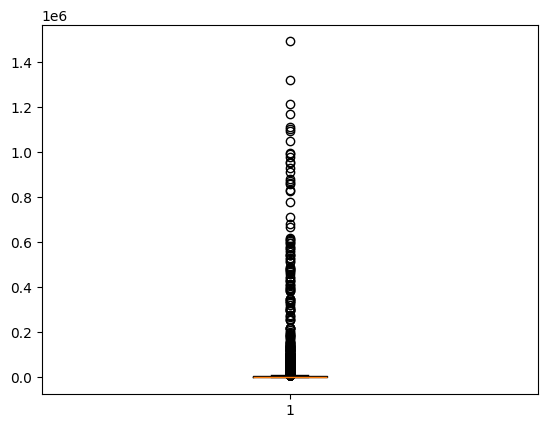

Deciles of all documents length /n >> [   67.  1412.  2138.  2687.  3232.  3865.  4619.  5569.  7177. 10323.]
Deciles of internal documents length /n >> [ 28749. 117981. 217730. 323361. 387622. 461123. 530884. 606460. 859091.
 992910.]
We will truncate 0.37% of the documents to 500k characters
It represents 42.86% of the internal documents


100%|██████████| 11531/11531 [00:00<00:00, 32927.89it/s]


In [65]:
# Focus on the rows with a score and content
df_1 = df[np.logical_and(
    np.logical_not(df['n_chunks'].isnull()),
    np.logical_not(df['content'].isnull())
)]

# Add a column with the number of characters to truncate overly long documents
df_1["size_char"] = df_1["content"].apply(lambda x: len(x))
plt.boxplot(df_1["size_char"]) # huge right tail
plt.show()

deciles = np.percentile(df_1["size_char"], np.arange(0, 100, 10))
print("Deciles of all documents length","/n >>", deciles) # 90% of documents fall under 10k characters
deciles_int = np.percentile(df_1[df_1["internal"]==1]["size_char"], np.arange(0, 100, 10))
print("Deciles of internal documents length","/n >>", deciles_int) # However internal documents are much longer
print(f"We will truncate {len(df_1[df_1['size_char'] > 500000])/len(df_1):.2%} of the documents to 500k characters")
print(f"It represents {len(df_1[np.logical_and(df_1['size_char'] > 500000, df_1['internal']==1)])/len(df_1[df_1['internal']==1]):.2%} of the internal documents")

# Truncate documents to 500k characters
df_1.loc[:,"content"] = df_1.loc[:,"content"].progress_apply(lambda x: x[:500000] if len(x) > 500000 else x)

## 0.1. Have a look at the differences in target variable

We have already removed the rows where no text or score was available. Let us now have a look at the companies are the most common to be engaged in greenwashing. In this case, we can define them as the company where the difference between what they say and what external sources say they do is the biggest.

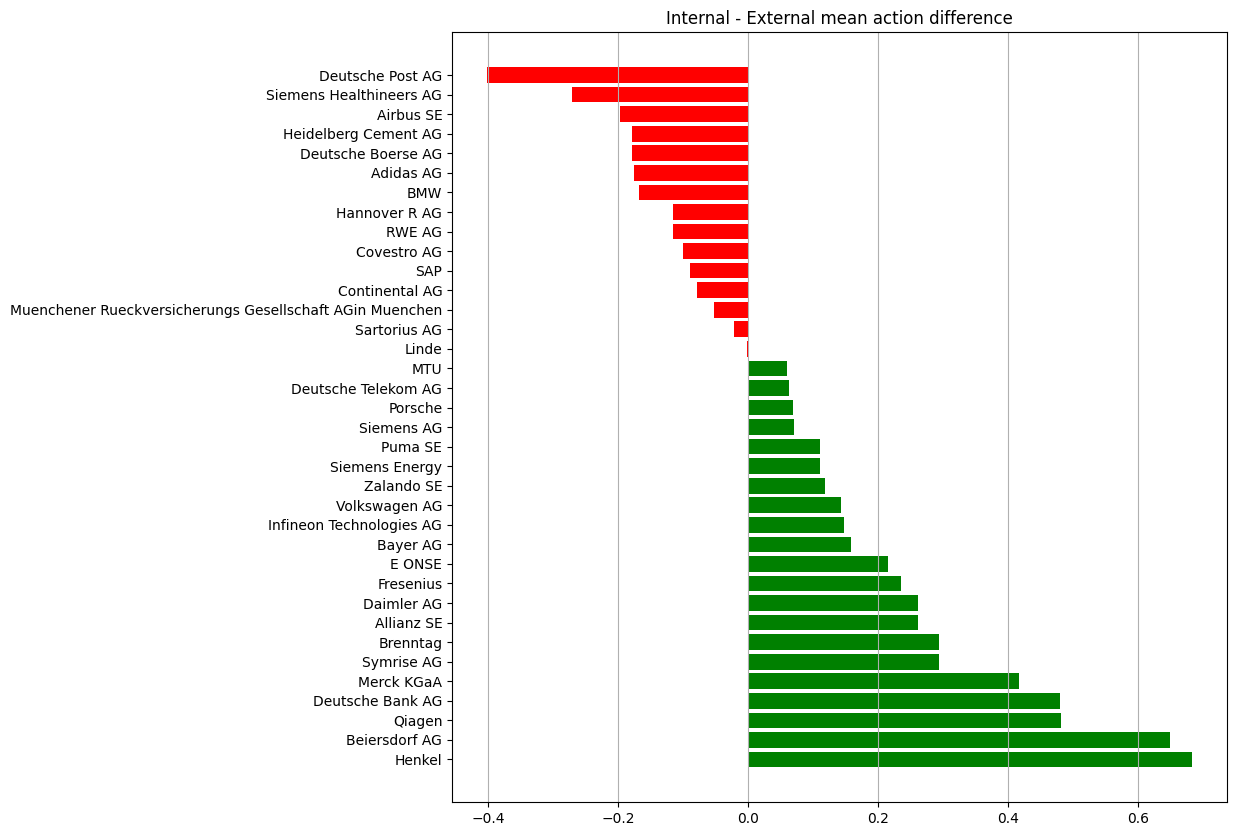

In [58]:
agg_table = df_1.groupby(["company","internal"]).agg({
    'mean_action_score': ['mean', 'min', 'max'], 'company': ["count"]
}).reset_index()

agg_table.columns = ["company","internal","mean_action_score_mean","mean_action_score_min","mean_action_score_max","count"]
agg_table

diff_table = agg_table[agg_table["internal"] == False].merge(
    agg_table[agg_table["internal"] == True],
    on="company",
    suffixes=("_external","_internal")
)

diff_table["mean_difference"] = diff_table["mean_action_score_mean_internal"] - diff_table["mean_action_score_mean_external"]
diff_table.sort_values("mean_difference", ascending=False, inplace=True)

plt.figure(figsize=(10,10))
plt.barh(
    diff_table["company"], diff_table["mean_difference"],
    color=np.where(diff_table["mean_difference"] > 0, "green", "red"))
plt.title("Internal - External mean action difference")
plt.grid(axis="x")
plt.show()


## 0.2. Have a look at the words frequency

We will clean the text and keep the lemma of the words to run some vizualisations on the frequency of the words.

In [33]:
# !python -m spacy download en_core_web_md
nlp = spacy.load("en_core_web_md")
stop_words = spacy.lang.en.stop_words.STOP_WORDS
punctuations = string.punctuation

c:\Users\User\Documents\VLERICK\NLP\vlerick-mai-nlp-2023\.env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [61]:
# We made sure that no text was over 500k characters so no try except needed to catch the exception
def spacy_tokenizer(sentence):
    """Transforms a sentence into a list of lemma tokens and remove stop words and punctuation.

    Parameters
    ----------
    sentence : str
        Input sentence.

    Returns
    -------
    list
        List of lemma tokens.
    """
    mytokens = nlp(sentence.lower())
    mytokens = [word for word in mytokens if not word.is_oov and not word.is_stop and not word.is_punct]
    mytokens = [word.lemma_.strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens]
    mytokens = [word for word in mytokens if word not in stop_words and word not in punctuations]
    return mytokens

We will tokenize all of the text and store it in a pickle to be able to use it later.

In [63]:
%%time

df_test = df_1.copy()
df_test = df_test.iloc[:10,:] # small dataset to test code on CPU

def tokenize_text(data, from_column, to_column):
    """Tokenize a column of text and add the result to a new column."""
    df_test[to_column] = df_test[from_column].progress_apply(spacy_tokenizer)    

tokenize_text(df_test, "content", "tokens")
print("The tokenisation of the first document reduces the number of characters (words -> lemma) from",
    len(df_test["content"][0]), "to", len(" ".join(df_test["tokens"][0]))) # Success

## Google Colab
# Tokenize all documents and save the result in a new pickle file
# tokenize_text(df_1, "content", "tokens")
# df_1.to_pickle("/content/drive/MyDrive/Masters 24/NLP/Data/esg_documents_for_dax_companies_with_scores_tokenized.pkl")

100%|██████████| 10/10 [03:18<00:00, 19.84s/it]

The tokenisation of the first document reduces the number of words from 56786 to 37412


# 1. Visualize the text information

Start with visualizing the words frequencies as number of words per document. We compare internal with external documents from `Henkel` and clearly see that there are a lot of mentions of sustainability, employees, and packaging in the internal documents. In the external documents, we see a lot of purely market-related words. By researching this gap, we find that `Henkel` under-delivers despite high promesses:

- https://vikajewels.com/blogs/blog-by-vika/what-is-really-behind-henkels-sustainability-initiative
- https://www.lsa-conso.fr/comment-le-chat-s-est-remis-au-vert-apres-son-bad-buzz,170775 (in French, there is a recovery after bad buzz)


In [ ]:
import pandas as pd
from collections import Counter
import tqdm
tqdm.tqdm.pandas()
import spacy
import string
import matplotlib.pyplot as plt
import numpy as np

# Google Colab
# from google.colab import drive
# drive.mount('/content/drive')
df = pd.read_pickle("https://media.githubusercontent.com/media/JosPolfliet/vlerick-mai-nlp-2023/Local/DATA/esg_documents_for_dax_companies_with_scores_tokenized.pkl")

df.head()

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 66/66 [00:22<00:00,  2.91it/s]


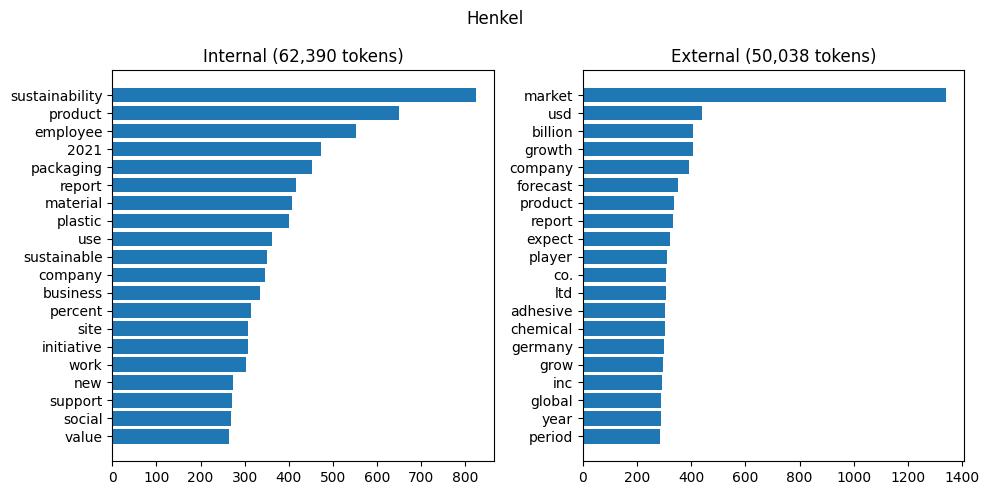

In [66]:
def countWordFrequencies(example, counter):
    tokens = spacy_tokenizer(example)
    counter.update(tokens)

def frequency_df(df, tokens = True):
    """Count the word frequencies in a dataframe.

    Parameters
    ----------
    df : DataFrame
        Initial dataframe with text in 'content' or tokens in 'tokens' column.
    tokens : bool, optional
        If we should use the token columns. If not, we first tokenize, by default True

    Returns
    -------
    DataFrame
        Word frequencies sorted by count.
    """
    counter = Counter()
    if tokens:
        df['tokens'].progress_apply(lambda x: counter.update(x))
    else:
        df['content'].progress_apply(lambda x: countWordFrequencies(x, counter))
    freq_df = pd.DataFrame.from_dict(counter, orient='index').reset_index()
    freq_df = freq_df.rename(columns={'index':'word', 0:'count'})
    freq_df = freq_df.sort_values(by='count', ascending=False)
    return freq_df

def compare_frequencies(df, company, save=False, top=20, directory='DATA/figures/'):
    """Plot the word frequencies for internal and external documents.

    Parameters
    ----------
    df : DataFrame
        Initial dataframe with text in 'content' or tokens in 'tokens' column.
    company : str
        Company to filter for.
    save : bool, optional
        Save the plot, by default False
    top : int, optional
        Numbers of most frequent words to keep, by default 20
    directory : str, optional
        Directory to save the plot, by default 'DATA/figures/'

    Returns
    -------
    None
    """
    df_1 = df[df['company'] == company]
    count_int = frequency_df(df_1[df_1['internal'] == 1])
    count_ext = frequency_df(df_1[df_1['internal'] == 0])
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10, 5))
    ax1.barh(count_int['word'][:top][::-1], count_int['count'][:top][::-1])
    ax1.set_title('Internal ({:,.0f} tokens)'.format(count_int['count'].sum()))
    ax2.barh(count_ext['word'][:top][::-1], count_ext['count'][:top][::-1])
    ax2.set_title('External ({:,.0f} tokens)'.format(count_ext['count'].sum()))
    plt.suptitle(company)
    plt.tight_layout()
    if save:
        plt.savefig('{}{}_word_frequencies.png'.format(directory,company))
    plt.show()

compare_frequencies(df_1, 'Henkel', save=True)

Then, we visualize the most common words per company in a wordcloud. We make the difference between the words that are in the company's report and the words that are in the external sources. We can already see some discrepancies between the two. If we look at the `Deutsche Bank` which was one of the most likely to greenwash according to the numerical action score, we see the words `trump`, `trump organization`, and `prosecutor` popping up in the external sources. This is probably due to the fact that the bank was [financially fooled by the Trump organization](https://www.forbes.com/sites/danalexander/2023/10/16/how-trump-fooled-deutsche-bank/). This is a good example of how the external sources can be used to detect unseen information.

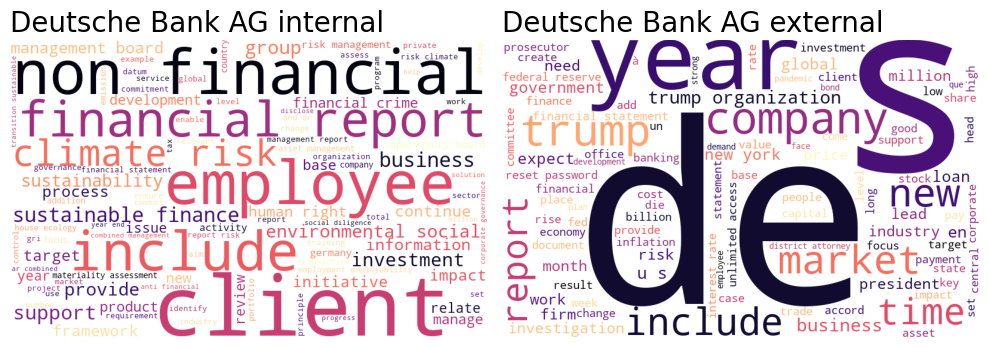

In [68]:
# inspired from https://medium.com/mlearning-ai/wordclouds-with-python-c287887acc8b

import numpy as np
from PIL import Image
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def add_wordcloud(text, company, ax, internal = True, random_state=42, tokens = True):
    if tokens:
        text.translate({ord(i): None for i in '[",]'}, inplace=True)
    else:
        text = " ".join(spacy_tokenizer(text))
    wc = WordCloud(background_color='white', colormap = 'magma', max_words=100,
        stopwords = spacy_tokenizer(company), height = 500, width = 800, random_state=random_state
        ).generate(text)
    ax.axis("off")
    ax.imshow(wc)
    ax.set_title(
        f'{company} {"internal" if internal else "external"}',
        color='black',fontsize=20,loc='left')

def compare_wordclouds(data, company, save=False, random_state=42, directory='DATA/figures/', tokens = True):
    df2 = data[data['company'] == company]
    df2int = df2[df2['internal'] == 1]
    df2ext = df2[df2['internal'] == 0]

    if tokens:
        text_int = " ".join(df2int['tokens'])
        text_ext = " ".join(df2ext['tokens'])

    else:
        text_int = " ".join(df2int['content'].tolist())
        text_ext = " ".join(df2ext['content'].tolist())

    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10, 5))
    try:
        add_wordcloud(text_int, company, ax1, random_state=random_state, tokens = tokens)
    except:
        add_wordcloud(text_int[:900000], company, ax1, random_state=random_state, tokens = tokens)
    try:
        add_wordcloud(text_ext, company, ax2, internal = False, random_state=random_state, tokens = tokens)
    except:
        add_wordcloud(text_ext[:900000], company, ax2, internal = False, random_state=random_state, tokens = tokens)
    plt.tight_layout()
    if save:
        plt.savefig(f'{directory}wordcloud_{company}.png')
    plt.show()

compare_wordclouds(df_1, 'Deutsche Bank AG', save=True, tokens=False)
# https://www.forbes.com/sites/danalexander/2023/10/16/how-trump-fooled-deutsche-bank/
# >> Trump issue

We can take the same approach to look at the differences in topics addressed. It looks like the variety of topics is much higher in the internal documents than in the external ones.

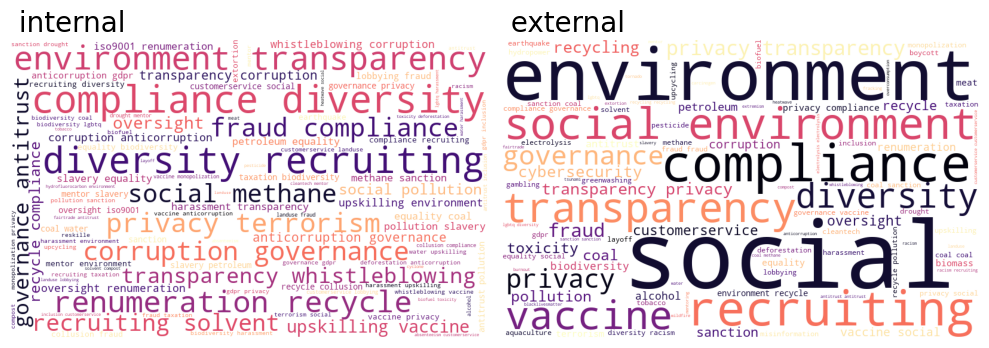

In [156]:
df2 = df_1
df2int = df2[df2['internal'] == 1]
df2ext = df2[df2['internal'] == 0]

text_int = " ".join(df2int['esg_topics'].tolist())
text_ext = " ".join(df2ext['esg_topics'].tolist())

company=""
random_state=42
save=True
directory='DATA/figures/'

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10, 5))
try:
    add_wordcloud(text_int, company, ax1, random_state=random_state)
except:
    add_wordcloud(text_int[:900000], company, ax1, random_state=random_state)
try:
    add_wordcloud(text_ext, company, ax2, internal = False, random_state=random_state)
except:
    add_wordcloud(text_ext[:900000], company, ax2, internal = False, random_state=random_state)
plt.tight_layout()
if save:
    plt.savefig(f'{directory}wordcloud_esg_topics.png')
plt.show()

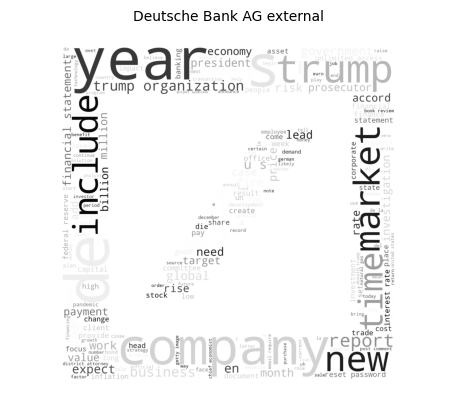

In [146]:
## Fancy word cloud with DB for the pitch

# DB_mask = np.array(Image.open("DATA/DB_logo.jpg"))

# wc = WordCloud(
#     background_color = 'white', mask = DB_mask, contour_width = 2, stopwords = spacy_tokenizer('Deutsche Bank AG'),
#     contour_color = 'white', colormap = 'Greys', width = 800, height = 500).generate(
#         " ".join(spacy_tokenizer(" ".join(df_1[np.logical_and(
#             df_1['company'] == 'Deutsche Bank AG',
#             df_1['internal'] == 0
#     )]['content'].to_list())[:900000])))
# plt.axis("off")
# plt.title('Deutsche Bank AG external', color='black',fontsize=10,loc='center')
# plt.imshow(wc)
# plt.savefig('DATA/figures/wordcloud_beautiful_external.png')
# plt.show()

In [3]:
from datasets import load_dataset
dataset = load_dataset("Emanuse/greenwashing_2")

c:\Users\User\Documents\VLERICK\NLP\vlerick-mai-nlp-2023\.env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Generating train split: 513 examples [00:00, 4331.09 examples/s]


In [11]:
gw_example = pd.DataFrame(dataset["train"])

# 2. Word embeddings to go beyond frequencies

There is only so much we can learn and especially interpret from the frequencies of words. We can use word embeddings to go beyond that. In fact, we want to see how close documents are to each other in the embedding space. This will enable us to see for which companies the internal and external documents are far appart which could a good indicator of greenwashing.

To go further, we will also use two additional datasets:
- SDG goals
- Greenwashing dataset

The goal is to see how precise companies are in their communication about their actions (a few SDGs or diffused goals). Then we will also see if the companies identified as more likely to greenwash with the action scores are also closer to the greenwashing dataset documents.